In [244]:
import itertools
import re
import pandas as pd
import numpy as np
import networkx as nx
import requests
import time
import math
import matplotlib.pyplot as plt
import json
import glob

from scipy.sparse import coo_matrix
from collections import Counter
from operator import itemgetter
from PIL import Image

In [181]:
characters = pd.read_csv("../data/characters.csv", usecols=['id', 'name', 'house'])
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1946 non-null   int64 
 1   name    1946 non-null   object
 2   house   1519 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.7+ KB


In [182]:
def resolve_identity(name, all_characters):
    """Resolves entities with hardcoded values from IMDB (main characters only)"""
    # clean names
    all_characters = [c.strip().lower() for c in all_characters]
    name = re.sub("[\(\[].*?[\)\]]", "", name).strip().lower()

    # known substitutions and nicknames for main characters only
    if "ned" in name:
        name = "eddard"
    elif name == "jon":
        name = "jon snow"
    elif bool([i for i in ["daenerys", "daenarys"] if(i in name)]):
        name = "daenerys"
    elif bool([i for i in ["jora", "jorah"] if(i in name)]):
        name = "jorah mormont"
    elif bool([i for i in ["samwell", "samwel", "sam"] if(i in name)]):
        name = "samwell tarly"
    elif name == "-robb":
        name = "robb"
    elif name == "varys":
        name = "lord varys"
    elif name == "davos":
        name = "davos seaworth"
    elif name == "brienne":
        name = "brienne of tarth"
    elif name == "king joffrey":
        name = "joffrey"
    elif bool([i for i in ["littlefinger", "petyr"] if(i in name)]):
        name = "petyr 'littlefinger' baelish"
    elif bool([i for i in ["clegane", "hound"] if(i in name)]):
        name = "sandor 'the hound' clegane"
    elif bool([i for i in ["gregor", "mountain"] if(i in name)]):
        name = "gregor 'the mountain' clegane"
    elif bool([i for i in ["khal", "drago"] if(i in name)]):
        name = "khal drago"
    
    # last names for main characters only
    if name in ["eddard", "catelyn", "sansa", "arya", "robb", "bran", "rickon", "telisa", "benjen", "lyanna"]:
        name += " stark"
    elif name in ["tyrion", "cersei", "jaime", "tywin", "lancel", "kevan", "alton"]:
        name += " lannister"
    elif name in ["theon", "yara", "euron", "balon"]:
        name += " greyjoy"
    elif name in ["daenerys", "viserys", "rhaegar"]:
        name += " targaryen"
    elif name in ["joffrey", "stannis", "tommen", "selyse", "shireen", "renly", "robert", "myrcella"]:
        name += " baratheon"
    elif name in ["margaery", "loras", "olenna", "mace"]:
        name += " tyrell"
    elif name in ["ramsay", "roose"]:
        name += " bolton"
    elif name in ["oberyn"]:
        name += " martell"
    
    # spelling
    if "targarian" in name:
        name = name.replace("targarian", "targaryen")
    
    return name

print(resolve_identity("Royce (person)", all_characters=characters))
print(resolve_identity("jon", all_characters=characters))
print(resolve_identity("ned", all_characters=characters))

royce
jon snow
eddard stark


In [183]:
with open ("../data/final_data.txt", "r") as f:
    data = f.readlines()
len(data)

33201

In [184]:
def split_dialogue_into_scenes(data):
    """
    Parse dialogue text into scenes.  Scenes appear to be split by [lines like this] and -------
    """
    scenes = []
    scene = []
    for text in data:
        # lines of dialogue begin with the speaker's name followed by a colon
        if ":" in text:
            scene.append(text)
        # breaks between scenes can either start and end with brackets or have a bunch of dashes
        if ("[" in text[:5] and "]" in text[-5:]) or "------" in text:
            if len(scene) > 0:
                scenes.append(scene)
            scene = []
    return scenes

In [185]:
scenes = split_dialogue_into_scenes(data)
len(scenes)

434

In [186]:
def get_nodes_and_edges_for_dialogue(scenes):
    """
    Create a set of characters (nodes) and their links/edges.  Characters speaking together in the same scene 
    will be assumed to be interacting, so an edge will be formed between them.  Edges will be undirected.  
    The edge list will contain tuples that can be used to build a graph.  Number of interactions could be used 
    as the edge weight.
    """
    nodes = set()
    edges = list()
    for scene in scenes:
        nodes_in_scene = set()
        for line in scene:
            node_name = resolve_identity(line.split(":")[0], all_characters=characters)
            nodes.add(node_name)
            nodes_in_scene.add(node_name)
        # assume everybody in the scene is interacting, so form links between all of them
        edges += list(itertools.combinations(nodes_in_scene, 2))
    return nodes, edges

In [187]:
nodes_by_name, edges = get_nodes_and_edges_for_dialogue(scenes)
print(len(nodes), len(edges))

475 52111


In [188]:
# create ID for each node
nodes = {i: v for i, v in enumerate(nodes_by_name)}
node_to_id_map = {v: k for k, v in nodes.items()}

In [189]:
# de-duplicate edges
edges_sorted = [tuple(sorted(tup, key = lambda x: x[0])) for tup in edges]
edges_weighted = dict(Counter(i for i in edges_sorted))
edges_weighted

{('gared', 'royce'): 3,
 ('royce', 'will'): 3,
 ('royce', 'waymar royce'): 1,
 ('gared', 'will'): 2,
 ('gared', 'waymar royce'): 1,
 ('will', 'waymar royce'): 1,
 ('septa mordane', 'sansa stark'): 1,
 ('eddard stark', 'robb stark'): 5,
 ('jon snow', 'robb stark'): 6,
 ('eddard stark', 'jon snow'): 6,
 ('cassel', 'catelyn stark'): 1,
 ('cassel', 'eddard stark'): 2,
 ('catelyn stark', 'eddard stark'): 11,
 ('bran stark', 'eddard stark'): 4,
 ('eddard stark', 'theon greyjoy'): 6,
 ('jon snow', 'theon greyjoy'): 6,
 ('cassel', 'jon snow'): 1,
 ('bran stark', 'jon snow'): 5,
 ('cassel', 'theon greyjoy'): 1,
 ('cassel', 'robb stark'): 1,
 ('bran stark', 'cassel'): 1,
 ('robb stark', 'theon greyjoy'): 7,
 ('bran stark', 'theon greyjoy'): 4,
 ('bran stark', 'robb stark'): 3,
 ('cersei lannister', 'jaime lannister'): 9,
 ('catelyn stark', 'maester luwin'): 2,
 ('luwin', 'maester luwin'): 1,
 ('catelyn stark', 'luwin'): 3,
 ('bran stark', 'catelyn stark'): 3,
 ('arya stark', 'eddard stark'): 4,


In [190]:
print(len(edges_weighted))

47234


In [191]:
def get_node_texts_for_dialogue(scenes, nodes_by_name):
    """
    Create dict of every character (node) and a list of their dialogue texts.  This can be used for NLP.
    """
    node_texts = dict.fromkeys(nodes_by_name)
    # initialize each character's text history as empty list
    node_texts = {node: [] for node, node_text in node_texts.items()}
    for scene in scenes:
        for line in scene:
            node_name = resolve_identity(line.split(":")[0], all_characters=characters)
            if len(node_name) > 0:  # skip breaks between scenes
                node_texts[node_name] += [line.split(":")[1].strip()]
    return node_texts

In [192]:
node_texts = get_node_texts_for_dialogue(scenes, nodes_by_name)
node_texts

{'night watch stable boy': ['Whoa, boy, whoa.'],
 'rorge': ['Give us a beer. Before I skin you.',
  'Hey, you little shit. Get us beer!',
  "Come closer. And I'll shove that stick up your bunghole and fuck you bloody.",
  'Come here!',
  'Come here!',
  "Look, it's Yoren's little cunt. Used to be a boy, now it's a girl.",
  "Don't care. Where's your stick now, bitch? I promised to fuck you with it.",
  "There's a price on your head.",
  "The king's dead. He drank poisoned wine at his own wedding. The bounty on you is for killing Lannister soldiers. 100 silver stags.",
  'Rorge.'],
 'stevron frey': ['Father, you forget yourself. Lady Stark is –'],
 'gared': ['We should head back to the wall.',
  'Our orders were to track the wildlings. We tracked them. They won’t trouble us no more.',
  'See where they went.',
  'It’s …'],
 'male singer': ['"And who are you," the proud lord said "That I must bow so low?" "Only a cat of a different coat "That\'s all the truth I know "In a coat of gold or

In [193]:
# convert edges dict to have edges by node ID
edges_weighted_by_id = {(node_to_id_map[k[0]], node_to_id_map[k[1]]): v for k, v in edges_weighted.items()}

# create sparse adjacency matrix
nbr_nodes = len(nodes)
matrix_shape = (nbr_nodes, nbr_nodes)
rows, cols = zip(*list(edges_weighted_by_id))
sparse_mat = coo_matrix((np.array(list(edges_weighted_by_id.values())), (rows, cols)), shape=matrix_shape)

The sparse matrix is not a true adjacency matrix.

In [363]:
def count_links_for_node(node_id, unique=True):
    row_indices = [r for r in rows if r == node_id]
    col_indices = [c for c in cols if c == node_id]
    sub_matrix = sparse_mat.todense()[row_indices,:]
    if unique:
        return len(row_indices) + len(col_indices)
    else:
        return "not implemented yet"

print(count_links_for_node(node_id=node_to_id_map["sansa stark"], unique=True))
print(count_links_for_node(node_id=node_to_id_map["sansa stark"], unique=False))

423
not implemented yet


In [387]:
output_df = pd.concat([
    pd.DataFrame(list(edges_weighted)),
    pd.DataFrame(list(edges_weighted_by_id)),
    pd.DataFrame(list(edges_weighted.values()))
], axis=1, ignore_index=True)
output_df.columns = ["name1", "name2", "id1", "id2"]# , "weight"]
output_df.to_csv("../data/edges.csv", index=False)
output_df.head()

,name1,name2,id1,id2
0,royce,gared,3,62
1,royce,will,62,133
2,royce,waymar royce,62,332
3,gared,will,3,133
4,gared,waymar royce,3,332


In [394]:
# sense check
pd.concat([
    output_df[((output_df.name1 == "sansa stark") | (output_df.name2 == "sansa stark"))]['name1'],
    output_df[((output_df.name1 == "sansa stark") | (output_df.name2 == "sansa stark"))]['name2']
]).drop_duplicates().to_list()

['septa mordane',
 'arya stark',
 'robert baratheon',
 'catelyn stark',
 'sansa stark',
 'king’s landing guard',
 'night watch stable boy',
 'benjen stark',
 'soldier',
 'pyp',
 'guard 1',
 'little bird',
 'steward',
 "petyr 'littlefinger' baelish",
 'varly',
 'rickon stark',
 'lord varys',
 'hugh of the vale',
 'rodrick cassel',
 'myrcella baratheon',
 'yoren',
 'old nan',
 'knight 2',
 'steward of house stark',
 'viserys targaryen',
 'tobho mott',
 'soldier 1',
 'masha heddle',
 'messenger',
 'brann stark',
 'knight 5',
 'rakharo',
 'remember this',
 'eddard stark',
 'ser alliser',
 'tomard',
 'jeor mormont',
 'beric dondarrion',
 'maryn trant',
 'greatjon umber',
 'tyrion lannister',
 'robb stark',
 'cersei baratheon',
 'street urchin',
 'eddark stark',
 "sandor 'the hound' clegane",
 'marillion',
 'man #6',
 'farlen',
 'jeor',
 'silk king',
 'watchman',
 'rorge',
 'woman #5',
 'ahsa',
 'olenna tyrell',
 'ser rodrik',
 'brinenne',
 'male singer',
 'steelshanks walton',
 'lothar',
 '

# Mario - see here

I think the data is ready.  I started working on creating the networkx graph below.  Could you put this into plotly/Dash?

In [404]:
# G = nx.from_scipy_sparse_array(sparse_mat)
G = nx.parse_edgelist([" ".join([str(t[0]), str(t[1])]) for t in list(edges_weighted_by_id)])

# determine node position from a given layout (use the spring layout)
pos = nx.spring_layout(G)

# assign node data attributes, such as position
for n in G.nodes:
    G.nodes[n]['pos'] = pos[n]
    G.nodes[n]['id'] = n
    G.nodes[n]['name'] = nodes[int(n)] # nodes[n]

In [410]:
centrality_betw = nx.betweenness_centrality(G, normalized=True, endpoints=False)
centrality_betw = {int(k): v for k, v in sorted(centrality_betw.items(), key=lambda item: item[1], reverse=True)}

In [411]:
output_df_nodes = pd.DataFrame.from_dict(
    nodes, orient="index"
).reset_index(drop=False).rename(columns={"index": "id", 0: "name"})
output_df_nodes['influence'] = output_df_nodes['id'].map(centrality_betw)
output_df_nodes.to_csv("../data/nodes.csv", index=False)
output_df_nodes.head()

,id,name,influence
0,0,night watch stable boy,0.000000
1,1,rorge,0.001736
2,2,stevron frey,0.000000
3,3,gared,0.000000
4,4,male singer,0.000000


In [210]:
# top 10 most influential
for n in list(centrality_betw)[:10]:
    print(nodes[n])

theon greyjoy
grenn
tyrion lannister
sansa stark
daenerys targaryen
arya stark
sandor 'the hound' clegane
jon snow
petyr 'littlefinger' baelish
tywin lannister


# What message should we send?

Let's suppose we want to spread the news that King's Landing has a weak point at the mud gate.  This was a true but little known fact in the show and proved to be a strategic location for attacking the city.  Who should we tell so that the message will spread across the network?  Who will care the most?  How should we word the message to get attention from those who will care?

In [237]:
ZERO_SHOT_ENDPOINT = "https://zero-shot-classification-dev.app.cision.com/"

In [242]:
# who talks about attacking King's Landing?
prompts = ["king's landing", "attack"]
raw_texts = [item.lower() for sublist in list(node_texts.values()) for item in sublist]
possible_texts = [v for v in raw_texts if prompts[0] in v and len(v) >= 50]  # documents mentioning King's Landing
print(len(possible_texts))

88


In [268]:
who_said_what = pd.concat(pd.DataFrame({'name':k, 'value':v}) for k, v in node_texts.items())
who_said_what['value'] = who_said_what['value'].astype(str).apply(lambda x: x.lower())
who_said_what.head()

,name,value
0,night watch stable boy,"whoa, boy, whoa."
0,rorge,give us a beer. before i skin you.
1,rorge,"hey, you little shit. get us beer!"
2,rorge,come closer. and i'll shove that stick up your...
3,rorge,come here!


In [243]:
possible_texts

["my lady. i wanted to personally welcome you to king's landing. the city has been made brighter by your presence.",
 "shall we go and see them? if you give them your love, they will return it a thousandfold. i've spoken with them. i know how they feel about you. you led the defense of king's landing. they adore you.",
 "i cannot defeat my brother in the field, and i can't take king's landing without the men he stole.",
 "we set out for king's landing without lady melisandre. and you lead the fleet into blackwater bay.",
 "i won't refuse. his grace summons me to king's landing, i'll go to king's landing.",
 "18,000. if i go to king's landing and bend my knee to joffrey...",
 "i'm sending one of your cousins down to king's landing with my peace terms.",
 "what can i do? attack king's landing? there's nothing he'd like better. he'd crush us in a day.",
 "oh, gods, no. petyr had three crates brought all the way from king's landing. he knew you liked lemon cakes. he's so kind. he really ca

In [321]:
all_ans = []
for t in possible_texts:
    data = {"text": t, "labels": ["i want to attack king's landing"]} # prompts}
    resp = requests.post(ZERO_SHOT_ENDPOINT, json=data)
    ans = resp.json()
    all_ans.append(ans)
    time.sleep(2)
print(len(all_ans))

88


In [323]:
highest_prob_of_attack = [a for a in all_ans if a['proba']["i want to attack king's landing"] > 0.5]
highest_prob_of_attack

[{'text': "i cannot defeat my brother in the field, and i can't take king's landing without the men he stole.",
  'proba': {"i want to attack king's landing": 0.9125010967254639}},
 {'text': "we set out for king's landing without lady melisandre. and you lead the fleet into blackwater bay.",
  'proba': {"i want to attack king's landing": 0.9508246183395386}},
 {'text': "what can i do? attack king's landing? there's nothing he'd like better. he'd crush us in a day.",
  'proba': {"i want to attack king's landing": 0.9818594455718994}},
 {'text': "no one will stay here. ser gregor will head out with 500 riders and set the riverland on fire from god's eye to the red fork. the rest of us will regroup at harrenhal. and you will go to king's landing.",
  'proba': {"i want to attack king's landing": 0.6049712896347046}},
 {'text': "you'll have your gold when we take the treasury at king's landing.",
  'proba': {"i want to attack king's landing": 0.8429799675941467}},
 {'text': "king's landing 

In [324]:
# who said those things?
who_probably_wants_to_attack_kings_landing = []
for i in highest_prob_of_attack:
    who_probably_wants_to_attack_kings_landing.append(who_said_what.loc[who_said_what['value'] == i['text'], 'name'].to_list())
set([i for p in who_probably_wants_to_attack_kings_landing for i in p])

{'brienne of tarth',
 'davos seaworth',
 'renly baratheon',
 'robb stark',
 'stannis baratheon',
 'theon greyjoy',
 'tywin lannister'}

In [325]:
# who said those things?
who_more_probably_wants_to_attack_kings_landing = []
for i in highest_prob_of_hostility:
    who_more_probably_wants_to_attack_kings_landing.append(
        (who_said_what.loc[who_said_what['value'] == i['text'], 'name'].to_list(), i['proba']['negative'])
    )
who_more_probably_wants_to_attack_kings_landing

[(['stannis baratheon'], 0.9403680562973022),
 (['robb stark'], 0.9269260764122009),
 (['lysa'], 0.5491369962692261),
 (['gendry'], 0.9588409066200256),
 (['tywin lannister'], 0.7412217259407043),
 (['thoros'], 0.641906201839447),
 (['davos seaworth'], 0.8468703627586365),
 (['tyrion lannister'], 0.697723388671875),
 (['tyrion lannister'], 0.9930347204208374),
 (['tyrion lannister'], 0.9547004699707031),
 (['tyrion lannister'], 0.5493941307067871),
 (['tyrion lannister'], 0.9780288338661194),
 (['tyrion lannister'], 0.5912368893623352),
 (['tyrion lannister'], 0.7918262481689453),
 (['tyrion lannister'], 0.9648007750511169),
 (['catelyn stark'], 0.9892763495445251),
 (['catelyn stark'], 0.9289891719818115),
 (['steelshanks walton'], 0.9295142292976379),
 (["petyr 'littlefinger' baelish"], 0.9635201692581177),
 (["petyr 'littlefinger' baelish"], 0.9245821833610535),
 (['sansa stark'], 0.553874671459198),
 (['sansa stark'], 0.8846442699432373),
 (['sansa stark'], 0.9559247493743896),
 ([

# Result

Any of these people are candidates to spread our message.  The next step is to simulate how the message might flow through the network, if we seed it through these people.

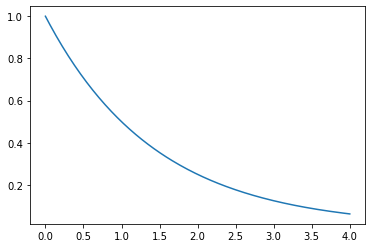

In [419]:
# create an exponential decay curve that mimics the 3 degrees of influence idea
# if influence to 1st degree is 0.5, then it halves every degree, meaning your influence curve by degree looks like:
influence_decay_curve = [0.5**x for x in np.linspace(0, 4, 200)]
plt.plot([x for x in np.linspace(0, 4, 200)], influence_decay_curve)

Idea: suppose every person's opinion on the issue can range from -1 (completely against) to 1 (completely for) and 0 (neutral).  Assume that relationship strength is the edge weight, and influence decays like the curve above.

net influence from A to B = A_opinion * A_to_B_w * A_to_B_degree_influence_val
So if B is 1st degree link and A fully supports: 1 * 3 * 0.5 = 1.5
If C is 2nd degree link and B kind of supports: (0.2*1.5) + (0.5 * 1 * 0.5) = 0.55


In [425]:
who_most_wants_to_attack = max(who_more_probably_wants_to_attack_kings_landing, key=itemgetter(1))
print(who_most_wants_to_attack)

(['shae'], 0.9980822801589966)


In [432]:
influence_decay = [who_most_wants_to_attack[1] * 0.5**x for x in range(0, 4, 1)]
print(influence_decay)

[0.9980822801589966, 0.4990411400794983, 0.24952057003974915, 0.12476028501987457]


In [702]:
min_desired_value = 0.15
max_desired_value = 1
scaled_influence_decay = [
    ((v - min(influence_decay)) / (max(influence_decay) - min(influence_decay))) # scale to (0,1)
    * (max_desired_value - min_desired_value) + min_desired_value  # re-scale to (min_desired_value, max_desired_value)
    for v in influence_decay
]
print(scaled_influence_decay)

[1.0, 0.5142857142857143, 0.2714285714285714, 0.15]


If we seed this person with the message, multiply these values ^ by the alpha value for a chosen color.  That will give the color of the nodal influence.  You could set the alpha for any other nodes outside 3 degrees to some number < 0.5.

But how about we combine opinion & influence to determine best person to seed?

In [479]:
ideal_seeds = []
influence_coef = 1
opinion_coef = 1
for p in who_more_probably_wants_to_attack_kings_landing:
    centrality_score = centrality_betw[node_to_id_map[p[0][0].strip()]]
    p += (centrality_score,)
    p += ((centrality_score * influence_coef ) * (p[1] * opinion_coef),)
    ideal_seeds.append(p)
ideal_seeds = sorted(ideal_seeds, key=lambda x: x[2], reverse=True)
for s in ideal_seeds:
    print(s)

(['theon greyjoy'], 0.9890066981315613, 0.022921089227161216, 0.022669110774133614)
(['tyrion lannister'], 0.697723388671875, 0.019952273093984584, 0.0139211675948416)
(['tyrion lannister'], 0.9930347204208374, 0.019952273093984584, 0.019813299933645178)
(['tyrion lannister'], 0.9547004699707031, 0.019952273093984584, 0.019048444499810895)
(['tyrion lannister'], 0.5493941307067871, 0.019952273093984584, 0.010961661732094077)
(['tyrion lannister'], 0.9780288338661194, 0.019952273093984584, 0.019513898387088092)
(['tyrion lannister'], 0.5912368893623352, 0.019952273093984584, 0.011796519879795261)
(['tyrion lannister'], 0.7918262481689453, 0.019952273093984584, 0.015798733546452007)
(['tyrion lannister'], 0.9648007750511169, 0.019952273093984584, 0.019249968545107875)
(['sansa stark'], 0.553874671459198, 0.01713221815678435, 0.009489101702956238)
(['sansa stark'], 0.8846442699432373, 0.01713221815678435, 0.015155918623816766)
(['sansa stark'], 0.9559247493743896, 0.01713221815678435, 0.0

In [480]:
influence_decay = [ideal_seeds[0][3] * 0.5**x for x in range(0, 4, 1)]
print(influence_decay)

min_desired_value = 0.5
max_desired_value = 1
scaled_influence_decay = [
    ((v - min(influence_decay)) / (max(influence_decay) - min(influence_decay))) # scale to (0,1)
    * (max_desired_value - min_desired_value) + min_desired_value  # re-scale to (min_desired_value, max_desired_value)
    for v in influence_decay
]
print(scaled_influence_decay)

[0.022669110774133614, 0.011334555387066807, 0.0056672776935334035, 0.0028336388467667018]
[1.0, 0.7142857142857143, 0.5714285714285714, 0.5]


In [502]:
output_df_nodes['link_count'] = output_df_nodes['name'].apply(
    lambda x: count_links_for_node(node_id=node_to_id_map[x], unique=True)
)

In [561]:
names_to_keep = output_df_nodes[output_df_nodes['link_count'] > 300]['name'].drop_duplicates().tolist()
print(len(names_to_keep))

97


In [562]:
json_output = {
    "nodes": output_df_nodes[output_df_nodes['name'].isin(names_to_keep)].to_dict(orient="records"),
    "edges": output_df[
        ((output_df['name1'].isin(names_to_keep)) & (output_df['name2'].isin(names_to_keep)))
    ].groupby(['id1', 'id2'])['name1'].count().reset_index(drop=False).rename(
        columns={"id1": "source", "id2": "target", "name1": "value"}
    ).to_dict(orient="records")
}
with open("../myGraphData2.json", "w") as f:
    json.dump(json_output, f)

In [563]:
len(json_output['edges'])

4660

# Simulation

Graph the network in networkx and color the notes, export GIF

In [851]:
## DataFrame
name_a = []
name_b = []
weight_ab = []
for k, v in edges_weighted.items():
    name_a.append(k[0])
    name_b.append(k[1])
    weight_ab.append(v)
print(len(name_a), len(name_b), len(weight_ab))

name_weights = {
    'Source': name_a, 
    'Target': name_b, 
    'weight' :weight_ab
}
df_name_weights=pd.DataFrame.from_dict(name_weights)

names = []
ids = []
for name, idx in node_to_id_map.items():
    names.append(name)
    ids.append(idx)
    
name_ids = {
    'names': names, 
    'id': ids
}
df_name_ids=pd.DataFrame.from_dict(name_ids)

##MainDataset
def data_source_target_ids(left_df, right_df, how_to_merge):
    
    hold = pd.merge(left_df, right_df.rename(columns={'names': 'Source'}), 
                    on=['Source'], how=how_to_merge)
    hold.rename(columns={'id':'id_Source'}, inplace=True)
    
    out = pd.merge(hold, right_df.rename(columns={'names': 'Target'}), 
                    on=['Target'], how=how_to_merge)
    out.rename(columns={'id':'id_Target'}, inplace=True)

    return out
df = data_source_target_ids(df_name_weights, df_name_ids, 'left')

###Data For NetworkGraphs
source_target_df = df.copy()

def df_for_analysis(dataset, val_a, val_b, two_vals=True):
    if two_vals:
        assert val_a < val_b, "Lower bound value is greater than upper bound value."
        df = dataset[(dataset['weight'] >=val_a) & (dataset['weight'] <=val_b)]
        print(df.shape)
    else:
        df = dataset[(dataset['weight'] == val_a)]
        print(df.shape)
    return df

df = df_for_analysis(source_target_df, 4, 5, two_vals=True) ##change range/or set two_vals to False ==> keep entries equal to val_a

##Check #character & connections
G = nx.from_pandas_edgelist(df, 
                            source='Source', 
                            target='Target', 
                            edge_attr='weight')
print("No of unique characters:", len(G.nodes))
print("No of connections:", len(G.edges))

47234 47234 47234
(106, 5)
No of unique characters: 50
No of connections: 105


In [852]:
# G = nx.from_scipy_sparse_array(sparse_mat)
# G = nx.parse_edgelist([" ".join([str(e['source']), str(e['target'])]) for e in json_output['edges']])

# determine node position from a given layout (use the spring layout)
pos = nx.spring_layout(G, seed=15)

remove = [node for node,degree in dict(G.degree()).items() if degree <5]
print("Removing:", remove)
G.remove_nodes_from(remove)

# assign node data attributes, such as position
for n in G.nodes:
    G.nodes[n]['pos'] = pos[n]
    G.nodes[n]['id'] = n
    # G.nodes[n]['name'] = [node['name'] for node in json_output['nodes'] if node['id'] == int(n)]

Removing: ['robb stark', 'ros', 'illyrio', 'viserys targaryen', "sandor 'the hound' clegane", 'jaime lannister', 'pyp', 'grenn', 'gendry', 'yoren', 'daenerys targaryen', 'mirri maz duur', 'jorah mormont', 'greatjon umber', 'guard', 'grand maester pycelle', 'man', 'kevan lannister', 'shae', 'ygritte', 'cut to', 'ramsay bolton', 'daario', 'brienne of tarth', 'podrick', 'qyburn', 'roose bolton', 'orell', 'tormund', 'talisa', 'grey worm', 'missandei', 'styr', 'ed', 'ralf']


Note for the future: all main characters interacted with every other main character over the course of the show

In [853]:
# colors = [(255/255, 0, 0, sid) for sid in scaled_influence_decay]
colors = [(1,0,0,1), (0,1,0,1), (0,0,1,1), (0,0,0,.15)]
print(colors)

[(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1), (0, 0, 0, 0.15)]


In [854]:
color_map = []

for n in G.nodes:
    if n == 'theon greyjoy':
        color_map.append(colors[0])
    else:
        color_map.append(colors[-1])

In [855]:
# plot params
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 22})

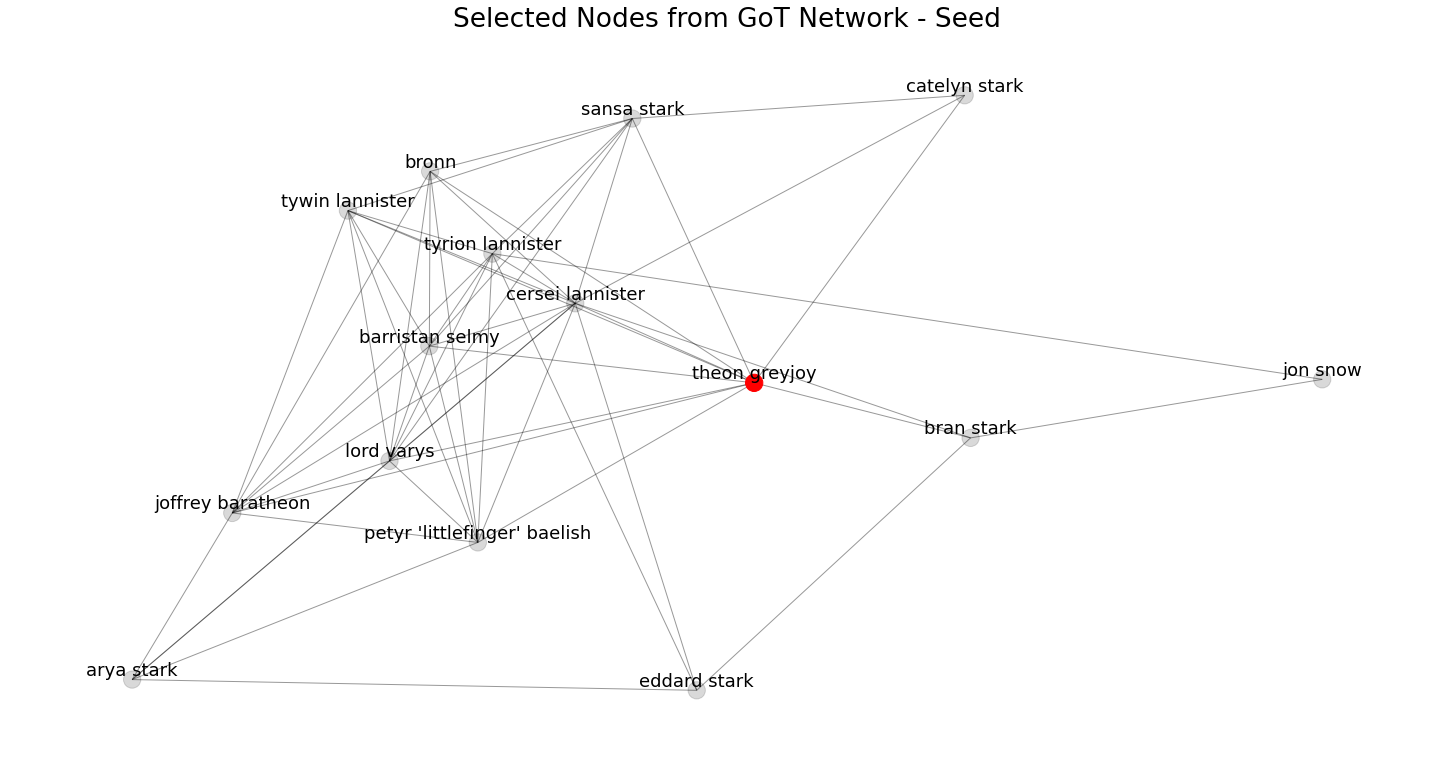

In [856]:
nx.draw(G, node_color=color_map, edge_color="#00000066", pos=pos, with_labels=True, font_size=18, verticalalignment="bottom")
plt.title("Selected Nodes from GoT Network - Seed")
plt.savefig('1.png', bbox_inches='tight')
plt.show()

In [857]:
degree_1_edges = [
    e[1] for e in G.edges("theon greyjoy") 
    if e[1] not in ['tywin lannister', 'cersei lannister', 'tyrion lannister']  # avoid these people
]
color_map = []
for n in G.nodes:
    if n == "theon greyjoy":
        color_map.append(colors[0])
    elif n in degree_1_edges:
        color_map.append(colors[1])
    else:
        color_map.append(colors[-1])

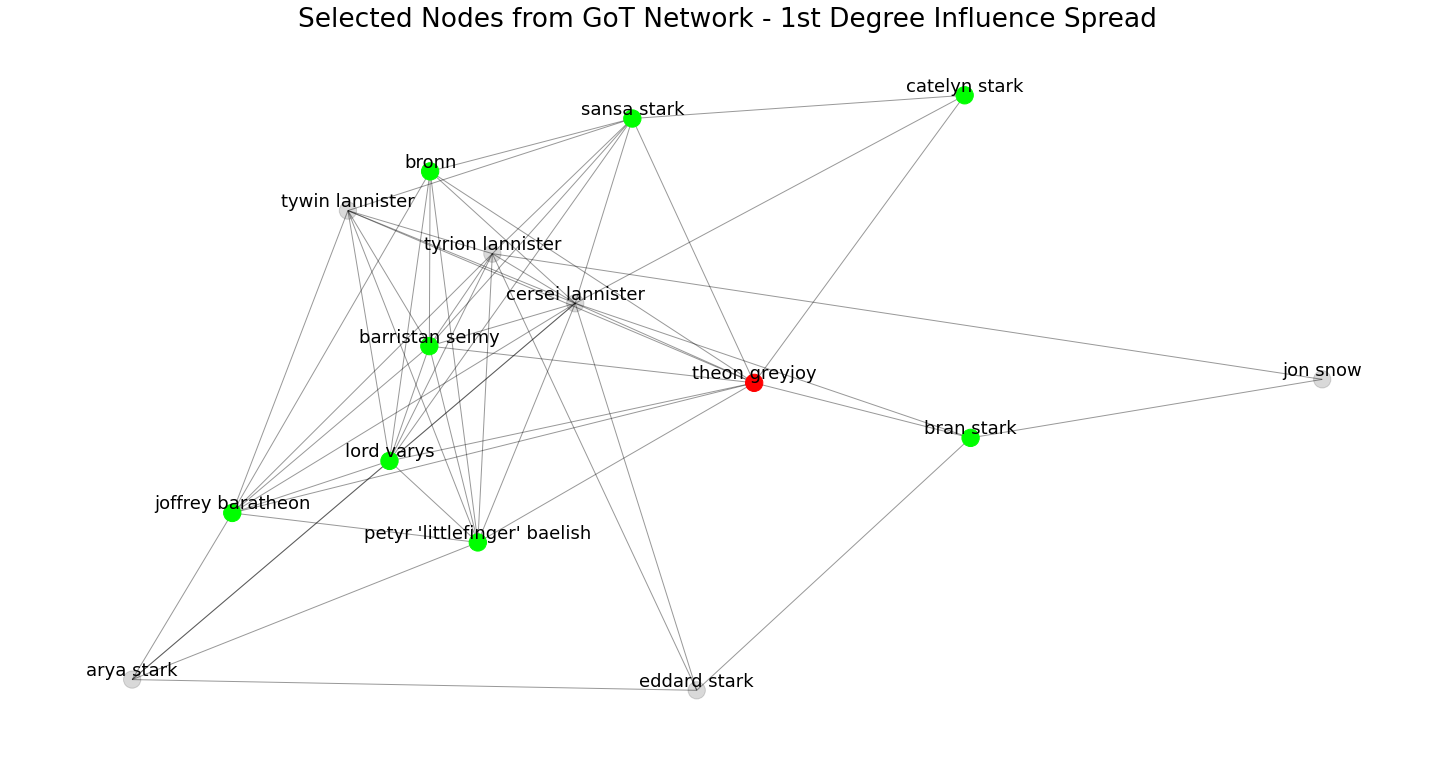

In [858]:
nx.draw(G, node_color=color_map, edge_color="#00000066", pos=pos, with_labels=True, font_size=18, verticalalignment="bottom")
plt.title("Selected Nodes from GoT Network - 1st Degree Influence Spread")
plt.savefig('2.png', bbox_inches='tight')
plt.show()

In [859]:
degree_2_edges = [
    e[1] for n in degree_1_edges + ["theon greyjoy"] for e in G.edges(n)
    if e[1] not in ['tywin lannister', 'cersei lannister', 'tyrion lannister']  # avoid these people
]
color_map = []
for n in G.nodes:
    if n == "theon greyjoy":
        color_map.append(colors[0])
    elif n in degree_1_edges:
        color_map.append(colors[1])
    elif n in degree_2_edges and n not in degree_1_edges:
        color_map.append(colors[2])
    else:
        color_map.append(colors[-1])

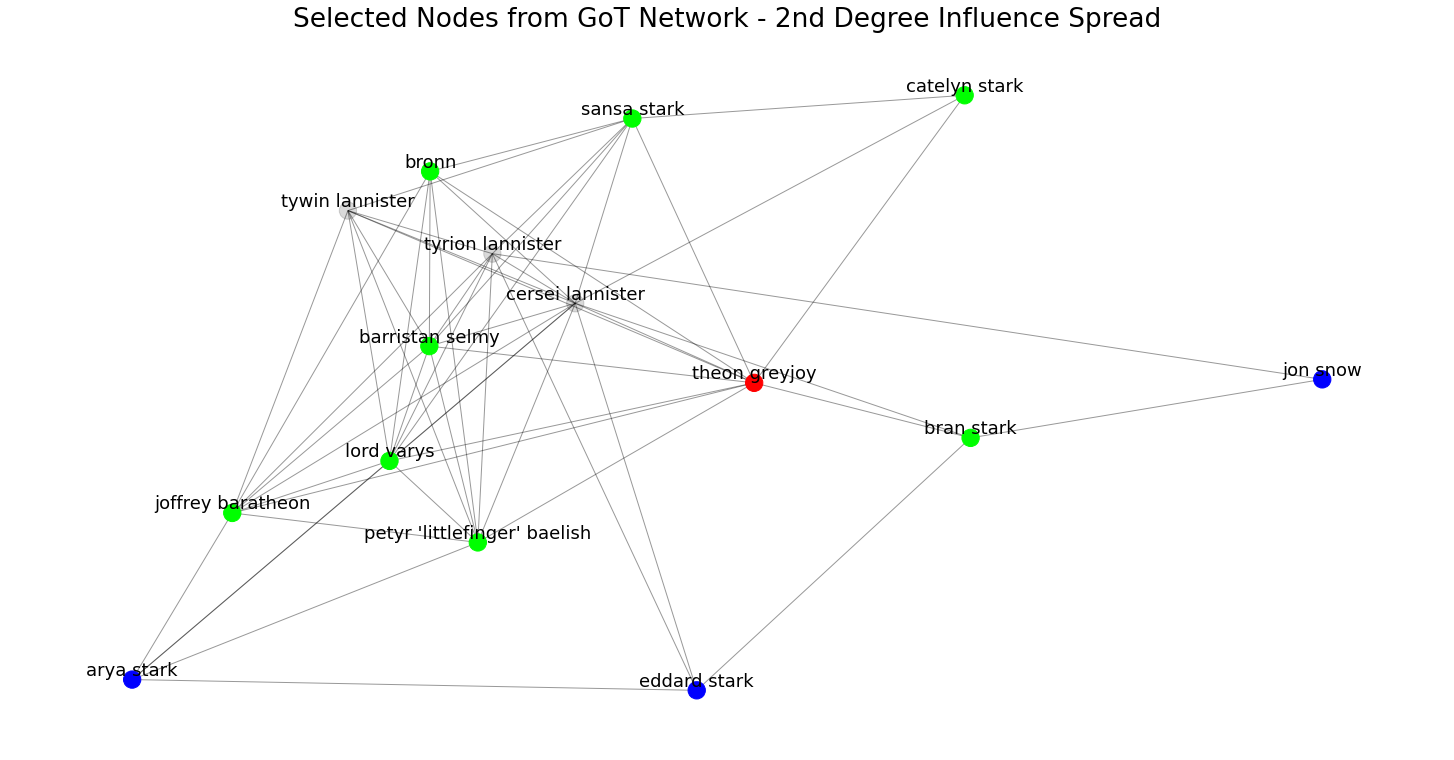

In [860]:
nx.draw(G, node_color=color_map, edge_color="#00000066", pos=pos, with_labels=True, font_size=18, verticalalignment="bottom")
plt.title("Selected Nodes from GoT Network - 2nd Degree Influence Spread")
plt.savefig('3.png', bbox_inches='tight')
plt.show()

In [861]:
fp_in = "*.png"
fp_out = "influence_spread_simulation.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1600, loop=0)

## Cleanup for presentation

In [870]:
seen = []
for s in ideal_seeds:
    if s[0][0] not in seen:
        print(
            "Character:", s[0][0], "\n",
            "Influence Score:", round(s[2], 2), "\n",
            "Opinion Favorability Score:", round(s[1], 2), "\n",
            "Composite Score:", round(s[3], 2), "\n\n"
        )
    seen.append(s[0][0])

Character: theon greyjoy 
 Influence Score: 0.02 
 Opinion Favorability Score: 0.99 
 Composite Score: 0.02 


Character: tyrion lannister 
 Influence Score: 0.02 
 Opinion Favorability Score: 0.7 
 Composite Score: 0.01 


Character: sansa stark 
 Influence Score: 0.02 
 Opinion Favorability Score: 0.55 
 Composite Score: 0.01 


Character: petyr 'littlefinger' baelish 
 Influence Score: 0.01 
 Opinion Favorability Score: 0.96 
 Composite Score: 0.01 


Character: tywin lannister 
 Influence Score: 0.01 
 Opinion Favorability Score: 0.74 
 Composite Score: 0.01 


Character: robb stark 
 Influence Score: 0.01 
 Opinion Favorability Score: 0.93 
 Composite Score: 0.01 


Character: jaime lannister 
 Influence Score: 0.01 
 Opinion Favorability Score: 0.98 
 Composite Score: 0.01 


Character: catelyn stark 
 Influence Score: 0.01 
 Opinion Favorability Score: 0.99 
 Composite Score: 0.01 


Character: jorah mormont 
 Influence Score: 0.01 
 Opinion Favorability Score: 0.98 
 Composite 

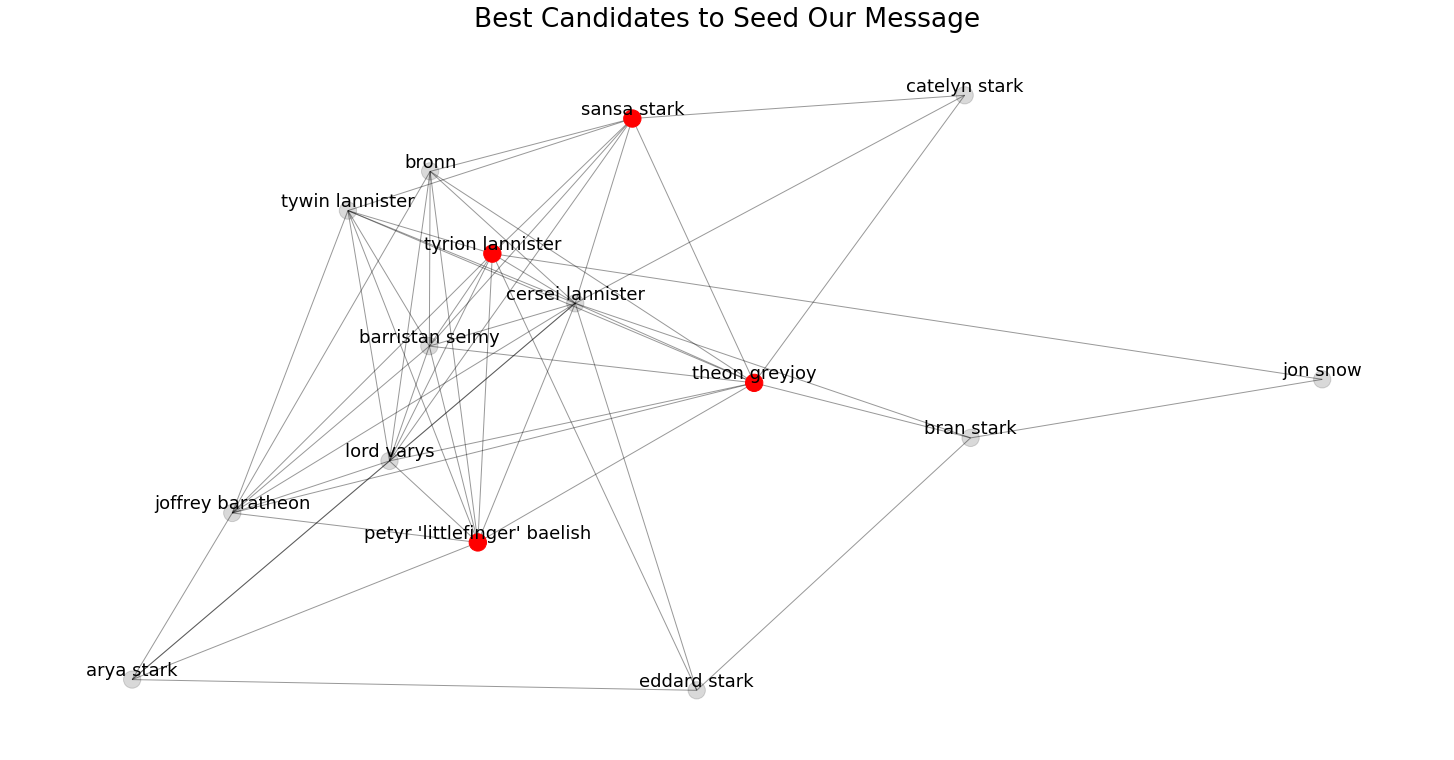

In [871]:
color_map = []
for n in G.nodes:
    if n in ["theon greyjoy", "tyrion lannister", "sansa stark", "petyr 'littlefinger' baelish", "robb stark"]:
        color_map.append(colors[0])
    else:
        color_map.append(colors[-1])

nx.draw(G, node_color=color_map, edge_color="#00000066", pos=pos, with_labels=True, font_size=18, verticalalignment="bottom")
plt.title("Best Candidates to Seed Our Message")
plt.savefig('best_candidates.png', bbox_inches='tight')
plt.show()

# Extra credit: VR

In [874]:
df.head()

,Source,Target,weight,id_Source,id_Target
7,eddard stark,robb stark,5,394,56
13,bran stark,eddard stark,4,289,394
17,bran stark,jon snow,5,289,415
22,bran stark,theon greyjoy,4,289,295
29,arya stark,eddard stark,4,298,394


In [877]:
nodes_kept_from_df = list(G.nodes())

In [892]:
df_sub = df[
    ((df['Source'].isin(nodes_kept_from_df)) & (df['Target'].isin(nodes_kept_from_df)))
].copy().reset_index(drop=True)
df_sub.head()

,Source,Target,weight,id_Source,id_Target
0,bran stark,eddard stark,4,289,394
1,bran stark,jon snow,5,289,415
2,bran stark,theon greyjoy,4,289,295
3,arya stark,eddard stark,4,298,394
4,cersei lannister,catelyn stark,4,171,239


In [897]:
df_sub.columns = [c.lower() for c in df_sub.columns]

In [902]:
json_output_new = {
    "nodes": [{"id": n} for n in list(set(df_sub['source'].tolist() + df_sub['target'].tolist()))],
    "links": df_sub[['source', 'target', 'weight']].rename(columns={"weight": "value"}).to_dict(orient="records"),
}
print(len(json_output_new['nodes']), len(json_output_new['links']))

15 56


In [904]:
with open("../virtual_reality_network/myGraphData.json", "w") as f:
    json.dump(json_output_new, f)